# Задание 4 - Перенос обучения (transfer learning) и тонкая настройка (fine-tuning)

Одной из важнейшних техник в тренировке сетей - использовать заранее натренированные веса на более общей задачи в качестве начальной точки, а потом "дотренировать" их на конкретной.

Такой подход и убыстряет обучение, и позволяет тренировать эффективные модели на маленьких наборах данных.

В этом упражнении мы натренируем классификатор, который отличает хотдоги от не хотдогов!  
(более подробно - https://www.youtube.com/watch?v=ACmydtFDTGs)

Это задание требует доступа к GPU, поэтому его можно выполнять либо на компьютере с GPU от NVidia, либо в [Google Colab](https://colab.research.google.com/).

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Feb 26 08:48:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout

from google.colab import files

#!pip3 install -q torch torchvision
#!pip3 install -q Pillow==4.0.0

Сначала давайте скачаем данные с картинками. Это сделает код в следующей ячейке. Данные будут разделены на две части. На обучающей выборке, которая будет храниться в папке **train_kaggle**, мы будем строить наши модели, а на тестовой выборке **test_kaggle** будем предсказывать класс, к которому относится фотография (хотдог или нет).

### Если вы в Google Colab!

В нем можно запускать ноутбуки с доступом к GPU. Они не очень быстрые, зато бесплатные!
Каждый ноутбук получает свой собственный environment c доступным диском итд.

Через 90 минут отсуствия активности этот environment пропадает со всеми данными.
Поэтому нам придется скачивать данные каждый раз.

In [3]:
# Download train data
!wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
!unzip -q "train.zip"

train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
!wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
!unzip -q "test.zip"

test_folder = "test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

--2022-02-26 08:48:30--  https://storage.googleapis.com/dlcourse_ai/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 142.251.8.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562348083 (536M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 536.30M  36.5MB/s    in 17s     

2022-02-26 08:48:49 (31.4 MB/s) - ‘train.zip’ saved [562348083/562348083]

Number of files in the train folder 4603
--2022-02-26 08:48:54--  https://storage.googleapis.com/dlcourse_ai/test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140788786 (134M) [application/zip]
Saving to: ‘test.zip’

t

In [4]:
import io

In [5]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!

# Имплементируем свой Dataset для загрузки данных

В этом задании мы реализуем свой собственный класс Dataset для загрузки данных. Его цель - загрузить данные с диска и выдать по ним тензор с входом сети, меткой и идентификатором картинки (так будет проще подготовить сабмит для kaggle на тестовых данных).

Вот ссылка, где хорошо объясняется как это делать на примере: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Ваш Dataset должен в качестве количества сэмплов выдать количество файлов в папке и уметь выдавать кортеж из сэмпла, метки по индексу и названия файла.
Если название файла начинается со слов 'frankfurter', 'chili-dog' или 'hotdog' - метка положительная. Иначе отрицательная (ноль).

И не забудьте поддержать возможность трансформации входа (аргумент `transforms`), она нам понадобится!

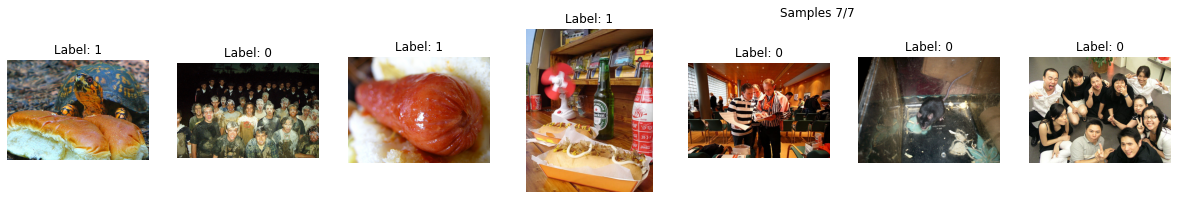

In [6]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.root_folder = folder
        self.labels = []
        for img in os.listdir(self.root_folder):
          if img.find('frankfurter')!=-1 or img.find('chili-dog')!=-1 or img.find('hotdog')!=-1:
            self.labels.append(1)
          else:
            self.labels.append(0)  
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):        
        img_id = os.listdir(self.root_folder)[index]
        img_name = os.path.join(self.root_folder, img_id)
        img = Image.open(img_name)
        y = self.labels[index]
        if self.transform:
          img = self.transform(img)
        return img, y, img_id

def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

In [11]:
orig_dataset[0][0].shape

AttributeError: ignored

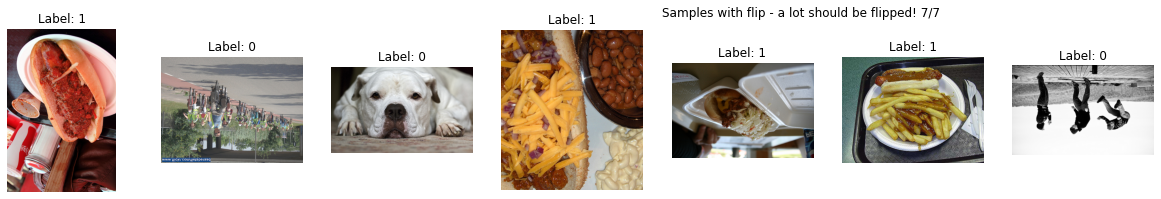

In [ ]:
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

# Создаем Dataset для тренировки

И разделяем его на train и validation.
На train будем обучать модель, на validation проверять ее качество, а соревнование Kaggle In-Class проведем на фотографиях из папки test_kaggle.

In [ ]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [ ]:
batch_size = 128

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Наши обычные функции для тренировки

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    accuracy = 0
    correct_samples = 0
    total_samples = 0
    with torch.no_grad():
      for _, (x, y,_) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        indices = torch.argmax(pred, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
        accuracy = float(correct_samples) / total_samples
    return accuracy

# Использование заранее натренированной сети (pretrained network)

Чаще всего в качестве заранее натренированной сети используется сеть, натренированная на данных ImageNet с 1M изображений и 1000 классами.

PyTorch включает такие натренированные сети для различных архитектур (https://pytorch.org/docs/stable/torchvision/models.html)  
Мы будем использовать ResNet18.

Для начала посмотрим, что выдает уже натренированная сеть на наших картинках. То есть, посмотрим к какому из 1000 классов их отнесет сеть.

Запустите модель на 10 случайных картинках из датасета и выведите их вместе с классами с наибольшей вероятностью.  
В коде уже есть код, который формирует соответствие между индексами в выходном векторе и классами ImageNet.

In [ ]:
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    # TODO: Process it to return dict of class index to name
    return { int(k): v[-1] for k, v in classes.items()}
    
model = models.resnet18(pretrained=True)

# TODO: Run this model on 10 random images of your dataset and visualize what it predicts

# Перенос обучения (transfer learning) - тренировать только последний слой

Существует несколько вариантов переноса обучения, мы попробуем основные.  
Первый вариант - заменить последний слой на новый и тренировать только его, заморозив остальные.

In [ ]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)


for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Average loss: 0.480022, Train accuracy: 0.758349, Val accuracy: 0.902174
Average loss: 0.262228, Train accuracy: 0.897366, Val accuracy: 0.928261


# Перенос обучения (transfer learning) - тренировать всю модель

Второй вариант - точно так же заменить последгний слой на новый и обучать всю модель целиком.

In [ ]:
import torch.nn as nn
import torch.optim as optim

# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

parameters = model.fc.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9)

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.507996, Train accuracy: 0.748303, Val accuracy: 0.900000
Average loss: 0.264159, Train accuracy: 0.895466, Val accuracy: 0.928261
Average loss: 0.214615, Train accuracy: 0.923704, Val accuracy: 0.923913
Average loss: 0.195620, Train accuracy: 0.934293, Val accuracy: 0.936957
Average loss: 0.179060, Train accuracy: 0.932664, Val accuracy: 0.933696


# Перенос обучения (transfer learning) - разные скорости обучения для разных слоев

И наконец последний вариант, который мы рассмотрим - использовать разные скорости обучения для новых и старых слоев

In [ ]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

parameters = model.fc.parameters()

loss = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    [
     {"params": model.fc.parameters(), "lr": 0.001},
     #{"params": model.lastlayer.parameters(), "lr": 0.0001},
    ], 
    lr=0.0001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.439411, Train accuracy: 0.803150, Val accuracy: 0.903261
Average loss: 0.251403, Train accuracy: 0.901168, Val accuracy: 0.922826
Average loss: 0.207302, Train accuracy: 0.926690, Val accuracy: 0.929348
Average loss: 0.191932, Train accuracy: 0.933478, Val accuracy: 0.931522
Average loss: 0.178337, Train accuracy: 0.937822, Val accuracy: 0.926087


# Визуализируем метрики и ошибки модели

Попробуем посмотреть, где модель ошибается - визуализируем ложные срабатывания (false positives) и ложноотрицательные срабатывания (false negatives).

Для этого мы прогоним модель через все примеры и сравним ее с истинными метками (ground truth).

In [ ]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    ground_truth = []
    predictions = []
    with torch.no_grad():
      sub_sampler = SubsetSampler(indices)
      loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=sub_sampler)
      
      for i_step, (x, y,_) in enumerate(loader):    
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        pred = model(x_gpu)
        res = torch.argmax(pred, 1)
        predictions.append(res)
        ground_truth.append(y_gpu)
      
      predictions = torch.cat(predictions)
      ground_truth = torch.cat(ground_truth)
    return predictions.cpu().detach().numpy(), ground_truth.cpu().detach().numpy()

predictions, gt = evaluate_model(model, train_dataset, val_indices)

И теперь можно визуализировать false positives и false negatives.

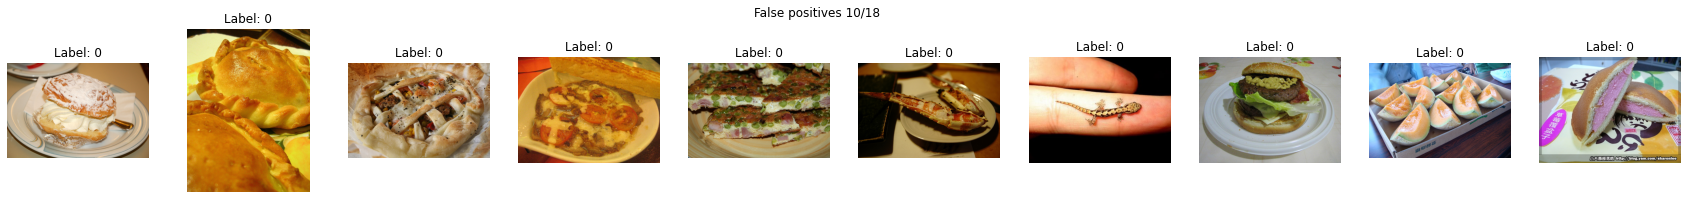

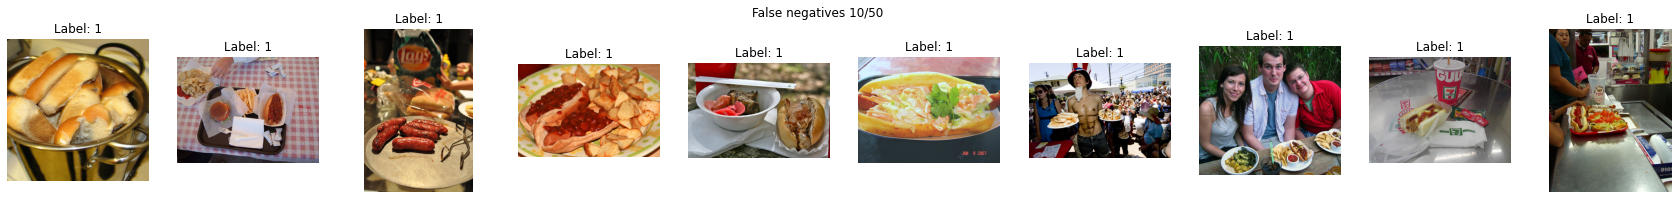

In [ ]:
# TODO: Compute indices of the false positives on the validation set.
# Note those have to be indices of the original dataset

false_positive_indices = []
for i in range(len(predictions)):
  if predictions[i]==1 and gt[i]==0:
    false_positive_indices.append(val_indices[i])
visualize_samples(orig_dataset, false_positive_indices, "False positives")

# TODO: Compute indices of the false negatives on the validation set.
# Note those have to be indices of the original dataset
false_negatives_indices = []
for i in range(len(predictions)):
  if predictions[i]==0 and gt[i]==1:
    false_negatives_indices.append(val_indices[i])
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")


In [ ]:
import sklearn.metrics as metrics
def binary_classification_metrics(prediction, ground_truth):
    # TODO: Implement this function!
    # We did this already it in the assignment1
    precision = 0
    recall = 0
    #accuracy = 0
    f1 = 0

    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(len(prediction)):
        if prediction[i]==ground_truth[i]==True:
            TP += 1
        elif prediction[i]==ground_truth[i]==False:
            TN += 1
        elif prediction[i]==True and ground_truth[i]==False:
            FP += 1
        elif prediction[i]==False and ground_truth[i]==True:
            FN += 1
    
    #accuracy = TP + TN / TP + TN + FP + FN
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = TP / (TP + 0.5 * (FP + FN) + 1e-6)
    #return precision, recall, f1, accuracy
    return precision, recall, f1

precision, recall, f1 = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.874, P: 0.929, R: 0.825


# Что будет в конце вы уже поняли

Натренируйте лучшую модель на основе `resnet18`, меняя только процесс тренировки.
Выбирайте лучшую модель по F1 score.

Как всегда, не забываем:
- побольше агментаций!
- перебор гиперпараметров
- различные оптимизаторы
- какие слои тюнить
- learning rate annealing
- на какой эпохе останавливаться

Наша цель - довести F1 score на validation set до значения, большего **0.93**.

In [ ]:
# TODO: Train your best model!
best_model = None


In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Epoch %i. Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch+1, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

# Resnet18 с SGD, обучается вся сеть, разная скорость обучения на последнем слое. 20 эпох.

In [ ]:
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

parameters = model.fc.parameters()

loss = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    [
     {"params": model.fc.parameters(), "lr": 0.001},
    ], 
    lr=0.0001, momentum=0.9)
loss_history, train_history, val_history = train_model(
    model, train_loader, val_loader, loss, optimizer, 10)

Average loss: 0.534845, Train accuracy: 0.727396, Val accuracy: 0.863043
Average loss: 0.263876, Train accuracy: 0.895194, Val accuracy: 0.898913
Average loss: 0.213934, Train accuracy: 0.924518, Val accuracy: 0.916304
Average loss: 0.195970, Train accuracy: 0.930220, Val accuracy: 0.922826
Average loss: 0.183981, Train accuracy: 0.935107, Val accuracy: 0.921739
Average loss: 0.171265, Train accuracy: 0.936465, Val accuracy: 0.939130
Average loss: 0.165695, Train accuracy: 0.941081, Val accuracy: 0.938043
Average loss: 0.160283, Train accuracy: 0.941895, Val accuracy: 0.932609
Average loss: 0.155032, Train accuracy: 0.945153, Val accuracy: 0.934783
Average loss: 0.152634, Train accuracy: 0.943253, Val accuracy: 0.944565


In [ ]:
loss_history, train_history, val_history = train_model(
    model, train_loader, val_loader, loss, optimizer, 10)

Average loss: 0.150366, Train accuracy: 0.945153, Val accuracy: 0.943478
Average loss: 0.147898, Train accuracy: 0.947597, Val accuracy: 0.945652
Average loss: 0.144074, Train accuracy: 0.949226, Val accuracy: 0.945652
Average loss: 0.140615, Train accuracy: 0.950855, Val accuracy: 0.946739
Average loss: 0.141189, Train accuracy: 0.951127, Val accuracy: 0.944565
Average loss: 0.143766, Train accuracy: 0.948955, Val accuracy: 0.945652
Average loss: 0.138623, Train accuracy: 0.948683, Val accuracy: 0.946739
Average loss: 0.141380, Train accuracy: 0.948412, Val accuracy: 0.946739
Average loss: 0.138122, Train accuracy: 0.949226, Val accuracy: 0.946739
Average loss: 0.135123, Train accuracy: 0.949498, Val accuracy: 0.945652


# Resnet18 с Adam, обучается вся сеть, разная скорость обучения на последнем слое. 20 эпох.

In [ ]:
model_adam = models.resnet18(pretrained=True)

num_ftrs = model_adam.fc.in_features
model_adam.fc = nn.Linear(num_ftrs, 2)
model_adam = model_adam.to(device)

parameters = model_adam.fc.parameters()

loss = nn.CrossEntropyLoss()


optimizer = optim.Adam([
     {"params": model_adam.fc.parameters(), "lr": 1e-3},
    ], 
    lr=1e-4, weight_decay=1e-4, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
loss_history, train_history, val_history = train_model(
    model_adam, train_loader, val_loader, loss, optimizer, 15)


Average loss: 0.607109, Train accuracy: 0.715449, Val accuracy: 0.852174
Average loss: 0.310387, Train accuracy: 0.873744, Val accuracy: 0.913043
Average loss: 0.250425, Train accuracy: 0.906869, Val accuracy: 0.925000
Average loss: 0.214336, Train accuracy: 0.924790, Val accuracy: 0.922826
Average loss: 0.191341, Train accuracy: 0.934021, Val accuracy: 0.935870
Average loss: 0.182497, Train accuracy: 0.934836, Val accuracy: 0.940217
Average loss: 0.172917, Train accuracy: 0.940538, Val accuracy: 0.935870
Average loss: 0.163873, Train accuracy: 0.940538, Val accuracy: 0.942391
Average loss: 0.156399, Train accuracy: 0.945153, Val accuracy: 0.941304
Average loss: 0.152200, Train accuracy: 0.947869, Val accuracy: 0.940217
Average loss: 0.145855, Train accuracy: 0.947597, Val accuracy: 0.938043
Average loss: 0.144345, Train accuracy: 0.949226, Val accuracy: 0.939130
Average loss: 0.143002, Train accuracy: 0.947869, Val accuracy: 0.940217
Average loss: 0.137400, Train accuracy: 0.948140, V

# Resnet18, Adam, обучается последний слой, lr=1e-4, 15 эпох.

In [ ]:
model_adam_freezed = models.resnet18(pretrained=True)

for param in model_adam_freezed.parameters():
    param.requires_grad = False

num_ftrs = model_adam_freezed.fc.in_features
model_adam_freezed.fc = nn.Linear(num_ftrs, 2)
model_adam_freezed = model_adam_freezed.to(device)

parameters = model_adam_freezed.fc.parameters()

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(parameters,
    lr=1e-4, weight_decay=1e-4, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
loss_history, train_history, val_history = train_model(
    model_adam_freezed, train_loader, val_loader, loss, optimizer, 15)


Epoch 0. Average loss: 0.788378, Train accuracy: 0.577790, Val accuracy: 0.657609
Epoch 1. Average loss: 0.645451, Train accuracy: 0.674450, Val accuracy: 0.705435
Epoch 2. Average loss: 0.543442, Train accuracy: 0.726582, Val accuracy: 0.784783
Epoch 3. Average loss: 0.472883, Train accuracy: 0.781700, Val accuracy: 0.818478
Epoch 4. Average loss: 0.420417, Train accuracy: 0.827315, Val accuracy: 0.845652
Epoch 5. Average loss: 0.380899, Train accuracy: 0.857182, Val accuracy: 0.858696
Epoch 6. Average loss: 0.351487, Train accuracy: 0.871029, Val accuracy: 0.869565
Epoch 7. Average loss: 0.327350, Train accuracy: 0.886777, Val accuracy: 0.885870
Epoch 8. Average loss: 0.311543, Train accuracy: 0.894380, Val accuracy: 0.893478
Epoch 9. Average loss: 0.297076, Train accuracy: 0.893837, Val accuracy: 0.900000
Epoch 10. Average loss: 0.280359, Train accuracy: 0.906869, Val accuracy: 0.906522
Epoch 11. Average loss: 0.270060, Train accuracy: 0.911214, Val accuracy: 0.910870
Epoch 12. Aver

# Resnet18, Adam, обучается вся сеть, lr-annealing, 20 эпох.

In [ ]:
def train_model_with_annealing(model, train_loader, val_loader, loss, optimizer, num_epochs, sheduler):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        sheduler.step()

        print("Epoch %i. Average loss: %f, Train accuracy: %f, Val accuracy: %f"
         % (epoch+1, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [ ]:
model_adam_annealing = models.resnet18(pretrained=True)

num_ftrs = model_adam_annealing.fc.in_features
model_adam_annealing.fc = nn.Linear(num_ftrs, 2)
model_adam_annealing = model_adam_annealing.to(device)

parameters = model_adam_annealing.fc.parameters()

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(parameters,
    lr=1e-4, weight_decay=1e-4, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
loss_history, train_history, val_history = train_model_with_annealing(
    model_adam_annealing, train_loader, val_loader, loss, optimizer, 20,
    sheduler)

Epoch 0. Average loss: 0.657402, Train accuracy: 0.653815, Val accuracy: 0.703261
Epoch 1. Average loss: 0.534748, Train accuracy: 0.726853, Val accuracy: 0.766304
Epoch 2. Average loss: 0.454185, Train accuracy: 0.800163, Val accuracy: 0.822826
Epoch 3. Average loss: 0.396096, Train accuracy: 0.839261, Val accuracy: 0.854348
Epoch 4. Average loss: 0.361281, Train accuracy: 0.869943, Val accuracy: 0.866304
Epoch 5. Average loss: 0.332707, Train accuracy: 0.878903, Val accuracy: 0.881522
Epoch 6. Average loss: 0.310410, Train accuracy: 0.892750, Val accuracy: 0.885870
Epoch 7. Average loss: 0.291903, Train accuracy: 0.896280, Val accuracy: 0.895652
Epoch 8. Average loss: 0.281038, Train accuracy: 0.903611, Val accuracy: 0.904348
Epoch 9. Average loss: 0.267276, Train accuracy: 0.909585, Val accuracy: 0.904348
Epoch 10. Average loss: 0.256107, Train accuracy: 0.915558, Val accuracy: 0.904348
Epoch 11. Average loss: 0.254603, Train accuracy: 0.911485, Val accuracy: 0.907609
Epoch 12. Aver

# Resnet18, Adam, обучается вся сеть, 10 эпох, horizontalflip/verticalflip.

In [ ]:
print(len(os.listdir(train_folder)))

4603


In [ ]:
#dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

train_dataset_vertical = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           #transforms.RandomHorizontalFlip(0.7),
                           transforms.RandomVerticalFlip(0.9),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )


batch_size = 512

train_loader_vertical = torch.utils.data.DataLoader(train_dataset_vertical, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader_vertical = torch.utils.data.DataLoader(train_dataset_vertical, 
                                         batch_size=batch_size,
                                         sampler=val_sampler)

In [ ]:
model_adam_aug_ver = models.resnet18(pretrained=True)

num_ftrs = model_adam_aug_ver.fc.in_features
model_adam_aug_ver.fc = nn.Linear(num_ftrs, 2)
model_adam_aug_ver = model_adam_aug_ver.to(device)

parameters = model_adam_aug_ver.fc.parameters()

loss = nn.CrossEntropyLoss()

#optimizer = optim.Adam([
#     {"params": model_adam_aug_ver.fc.parameters(), "lr": 1e-3},
#    ], 
#    lr=1e-3, weight_decay=1e-5, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
#loss_history, train_history, val_history = train_model(
#    model_adam_aug_ver, train_loader_vertical, val_loader_vertical, loss, optimizer, 15)
optimizer = optim.Adam(parameters,
    lr=1e-2, weight_decay=1e-4, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
loss_history, train_history, val_history = train_model_with_annealing(
    model_adam_aug_ver, train_loader_vertical, val_loader_vertical, loss, optimizer, 20,
    sheduler)

Epoch 1. Average loss: 0.921148, Train accuracy: 0.692913, Val accuracy: 0.838043
Epoch 2. Average loss: 0.315477, Train accuracy: 0.883247, Val accuracy: 0.913043
Epoch 3. Average loss: 0.222039, Train accuracy: 0.918273, Val accuracy: 0.919565
Epoch 4. Average loss: 0.193727, Train accuracy: 0.927233, Val accuracy: 0.918478
Epoch 5. Average loss: 0.179478, Train accuracy: 0.929677, Val accuracy: 0.935870
Epoch 6. Average loss: 0.169373, Train accuracy: 0.939180, Val accuracy: 0.940217
Epoch 7. Average loss: 0.178423, Train accuracy: 0.935107, Val accuracy: 0.926087
Epoch 8. Average loss: 0.160973, Train accuracy: 0.936736, Val accuracy: 0.934783
Epoch 9. Average loss: 0.173132, Train accuracy: 0.932664, Val accuracy: 0.925000
Epoch 10. Average loss: 0.158953, Train accuracy: 0.942710, Val accuracy: 0.934783
Epoch 11. Average loss: 0.156623, Train accuracy: 0.938094, Val accuracy: 0.932609
Epoch 12. Average loss: 0.159496, Train accuracy: 0.938365, Val accuracy: 0.939130


KeyboardInterrupt: ignored

In [ ]:
from collections import namedtuple
import random

In [ ]:
def initialize_model():
  model = models.resnet18(pretrained=True)

  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)
  model = model.to(device)

  parameters = model.fc.parameters()
  return parameters, model

In [ ]:
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
#anneal_coeff = 0.2
anneal_epochs = [3, 5, 7]
#reg = [1e-3, 1e-4, 1e-5, 1e-7]

random_lr = random.sample(learning_rates, 3)
#random_ae = random.sample(anneal_epochs, 3) 
epoch_num = 10


# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 
for lrp in random_lr:
  for ae in anneal_epochs:
      print('-------------', lrp, ae)
      params, model = initialize_model()
      loss = nn.CrossEntropyLoss()
      optimizer = optim.Adam(params,
        lr=1e-2, weight_decay=1e-4, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
      sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=ae, gamma=0.5)
      loss_history, train_history, val_history = train_model_with_annealing(
        model, train_loader_vertical, val_loader_vertical, loss, 
        optimizer, epoch_num, sheduler)
      run_record[Hyperparams(lrp,ae)] = RunResult(model,train_history,val_history,val_history[len(val_history)-1])

------------- 0.0001 3
Epoch 1. Average loss: 1.781933, Train accuracy: 0.535976, Val accuracy: 0.846739
Epoch 2. Average loss: 0.581630, Train accuracy: 0.793646, Val accuracy: 0.829348
Epoch 3. Average loss: 0.413975, Train accuracy: 0.852023, Val accuracy: 0.898913
Epoch 4. Average loss: 0.293353, Train accuracy: 0.896280, Val accuracy: 0.897826
Epoch 5. Average loss: 0.255276, Train accuracy: 0.900896, Val accuracy: 0.921739
Epoch 6. Average loss: 0.220737, Train accuracy: 0.918545, Val accuracy: 0.930435
Epoch 7. Average loss: 0.217305, Train accuracy: 0.921260, Val accuracy: 0.921739
Epoch 8. Average loss: 0.217149, Train accuracy: 0.925061, Val accuracy: 0.930435
Epoch 9. Average loss: 0.207335, Train accuracy: 0.928319, Val accuracy: 0.929348
Epoch 10. Average loss: 0.211775, Train accuracy: 0.926690, Val accuracy: 0.926087
------------- 0.0001 5
Epoch 1. Average loss: 1.146473, Train accuracy: 0.665219, Val accuracy: 0.830435
Epoch 2. Average loss: 0.479701, Train accuracy: 0.

# Validation set performance

In [ ]:
best_model = model_adam_aug_ver

In [ ]:
# Let's check how it performs on validation set!
predictions, ground_truth = evaluate_model(best_model, train_dataset, val_indices)
precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

# TODO: Visualize training curve for the best model

F1: 0.907, P: 0.927, R: 0.888


# Test perfomance

In [ ]:
def evaluate_model_test(model, dataset):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    ground_truth = []
    predictions = []
    with torch.no_grad():
      loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
      
      for i_step, (x, y,_) in enumerate(loader):    
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        pred = model(x_gpu)
        res = torch.argmax(pred, 1)
        predictions.append(res)
        ground_truth.append(y_gpu)
      
      predictions = torch.cat(predictions)
      ground_truth = torch.cat(ground_truth)
    return predictions.cpu().detach().numpy(), ground_truth.cpu().detach().numpy()


In [ ]:
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [ ]:
predictions, ground_truth = evaluate_model_test(best_model, test_dataset)
precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

[0 1 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
1150
1150


ZeroDivisionError: ignored

## Визуализируйте ошибки лучшей модели

In [ ]:
# TODO Visualize false positives and false negatives of the best model on the validation set

# Необязательное задание с большой звездочкой

Поучавствуйте в Kaggle In-Class Hot Dog Recognition Challenge!  
Это соревнование сделано специально для курса и в нем учавствуют только те, кто проходит курс.

В нем участники соревнуются в качестве натренированных моделей, загружая на сайт предсказания своих моделей на тестовой выборке. Разметка тестовой выборке участникам недоступна.
Более подробно о правилах соревнования ниже.

Те, кто проходят курс лично, за высокое место в соревновании получат дополнительные баллы.

Здесь уже можно использовать и другие базовые архитектуры кроме `resnet18`, и ансамбли, и другие трюки тренировки моделей.

Вот ссылка на соревнование:
https://www.kaggle.com/c/hotdogornot

In [ ]:
image_id = []
predictions = []
model.eval()
for x,_,id_img in test_loader:
    # TODO : Напишите код для предсказания меток (1 = есть хотдог, 0 = хотдога нет)
    # Код должен возвратить список из id картинки и метку predictions
    # image id - это название файла картинки, например '10000.jpg'
    pass

In [ ]:
# Так можно создать csv файл, чтобы затем загрузить его на kaggle
# Ожидаемый формат csv-файла:
# image_id,label
# 10000.jpg,1
# 10001.jpg,1
# 10002.jpg,0
# 10003.jpg,1
# 10004.jpg,0

with open('subm.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerow(['image_id', 'label'])
    writer.writerows(zip(image_id,predictions))

In [ ]:
# А так можно скачать файл с Google Colab
files.download('subm.csv') 

### Небольшое введение в Kaggle для тех, кто не слышал об этой платформе раньше

В основе своей Kaggle - это платформа для проведения соревнований по машинному обучению. Появилась она в 2010 и, пожалуй, стала самой популярной и известной из всех существующих площадок по машинному обучению. Надо сказать, что Kaggle - это не только соревнования, но и сообщество людей, увлеченных машинным обучением. А судя по Википедии, в 2017 году отметка зарегистрированных пользователей перевалила за миллион. Есть там и обучающие материалы, возможность задавать вопросы, делиться кодом и идеями - просто мечта. 

### Как проходят соревнования? 
Обычно участники скачивают данные для обучения моделей (train data), чтобы затем делать предсказания на тестовых данных (test data). Обучающая выборка содержит как сами данные, так и правильные метки (значения зависимой переменной), чтобы можно было обучить модель. Но тестовые данные ответа не содержат - и нашей целью является предсказание меток по имеющимся данным. Файл с ответами для каждого наблюдения из тестовой выборки загружается на Kaggle и оценивается в соответствии с выбранной метрикой соревнования, а результат является публичным и показывается в общей таблице (ее называют еще лидербордом - leaderboard) - чтобы появилось желание посоревноваться и создать еще более сильную модель. В "настоящих" соревнованиях, которые проходят на Kaggle, есть и денежное вознаграждение для тех участников, кто занимает первые места на лидерборде. Например, в [этом](https://www.kaggle.com/c/zillow-prize-1#description) соревновании, человек, занявший первое место, получил около 1 000 000 долларов. 

Тестовые данные делятся случайным образом в некоторой пропорции. И пока соревнование идет, на лидерборде показываются очки и рейтинг участников только по одной части (Public Leaderboard). А вот когда соревнование заканчивается, то рейтинг участников составляется по второй части тестовых данных (Private Leaderboard). И часто можно видеть, как люди занимавшие первые места на публичной части тестовых данных, оказываются далеко не первыми на закрытой части тестовых данных. Зачем это сделано? Есть несколько причин, но, пожалуй, самой фундаментальной является идея недообучения-переобучения. Всегда возможно, что наша модель настроилась на конкретную выборку, но как она поведет себя на тех данных, которые еще не видела? Разбиение тестовых данных на публичную и скрытую части сделано для того, чтобы отобрать модели, которые имеют большую обобщающую способность. Одним из лозунгов участников соревнований стал "Доверяйте своей локальной кросс-валидации" (Trust your CV!). Есть очень большой соблазн оценивать свою модель по публичной части лидерборда, но лучшей стратегией будет выбирать ту модель, которая дает лучшую метрику на кросс-валидации на обучающей выборке. 

В нашем соревновании публичная часть лидерборда составляет 30%, а скрытая 70%. Вы можете делать до двух попыток в день, а оцениваться попытки будут по F1-мере. Удачи и доверяйте своей локальной валидации! В конце соревнования у вас будет возможность выбрать 2 из всех совершенных попыток - лучшая из этих двух и будет засчитана вам на скрытой части тестовых данных.